<a href="https://colab.research.google.com/github/tranmanhcuong253/Vietnamese-RAG-Chatbot/blob/main/Vietnamese_RAG_Chatbot_Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# References

- 財團法人台北市艋舺龍山寺 https://www.lungshan.org.tw/index.php
- 籤詩網 http://www.chance.org.tw/
- 周公靈簽 https://www.golla.tw/chouqian
- 解籤閣 https://wisdomer2002.pixnet.net/blog/post/1965757
- 關於聖意 https://vocus.cc/article/60cc311efd8978000139e6c2
- 星玄説(https://astrologs.net/a/9kog8bd821/)
- openai models https://platform.openai.com/docs/models
- claude models https://docs.anthropic.com/en/docs/about-claude/models
- openai API https://github.com/openai/openai-python
- anthropic API https://github.com/anthropics/anthropic-sdk-python
- aisuite API https://github.com/andrewyng/aisuite
- neo4j API https://github.com/neo4j/neo4j-python-driver


# 0.Packages


In [1]:
%pip install ipython-autotime
%pip install gradio
%pip install neo4j
%pip install anthropic==0.40.0
%pip install openai==1.57.4
%pip install aisuite
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 5.1 MB/s eta 0:00:00
time: 316 µs (started: 2024-12-22 09:11:56 +00:00)


In [ ]:
%matplotlib inline

import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

time: 545 ms (started: 2024-12-17 04:04:39 +00:00)


# 1.Static mapping table


## System prompt template


In [ ]:
SYS_PROMPT_TPL: str = '\n'.join([
    ("You are an assistant specialized in interpreting divination results. "
     "Use the following [Context] to provide insights and advice to users based on their questions. "
     "Always format your responses according to the [Response Format] below, "
     "ensuring personalized interpretations and actionable advice."),
    "\n",
    "[Response Format] ",
    "您抽到的籤是: [Include 籤名 here] ",
    "籤詩: [Include full 籤詩 here] ",
    "\n",
    "籤詩解讀: ",
    "\n",
    "小廟公建議: ",
    "[Context] "
    "{context}"
    "\n"
    "Guidelines: "
    "- Interpret the provided [Context] flexibly. The \"籤詩解讀\" should connect the content of the divination with the user's question. "
    "- Use the \"小廟公建議\" to provide specific, actionable guidance relevant to the question, referencing details from the context where appropriate. "
    "- End with a short phrase encouraging the user, alike \"Don't worry\", \"Good luck\", etc. "
    "\n"
    "Note: "
    "If the length of the [Context] is less than 20 characters, provide the full [Context] directly as a response without applying the [Response Format]."
])

print(SYS_PROMPT_TPL)

You are an assistant specialized in interpreting divination results. Use the following [Context] to provide insights and advice to users based on their questions. Always format your responses according to the [Response Format] below, ensuring personalized interpretations and actionable advice.


[Response Format] 
您抽到的籤是: [Include 籤名 here] 
籤詩: [Include full 籤詩 here] 


籤詩解讀: 


小廟公建議: 
[Context] {context}
Guidelines: - Interpret the provided [Context] flexibly. The "籤詩解讀" should connect the content of the divination with the user's question. - Use the "小廟公建議" to provide specific, actionable guidance relevant to the question, referencing details from the context where appropriate. - End with a short phrase encouraging the user, alike "Don't worry", "Good luck", etc. 
Note: If the length of the [Context] is less than 20 characters, provide the full [Context] directly as a response without applying the [Response Format].
time: 5.27 ms (started: 2024-12-17 05:13:32 +00:00)


## RAG context template


In [ ]:
RAG_TPL: str = '\n'.join([
    "籤名: 【{吉凶}】{詩運} {籤名}-{詩名} ",
    "\n",
    "~籤詩~ ",
    "{籤詩}",
    "\n",
    "{詳解}",
    "\n",
    "小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! ",
    "{聖意}",
    "\n",
    "潛在的指示為地支「{地支}」, 也可給求籤者做相關提醒: ",
    " - 地理位置代表{方位} ",
    " - 時間為{時間} ",
    " - 十二生肖對應為{生肖}, {生肖特色}, {生肖從事} ",
    " - 五行為「{五行}」, {五行}生{相生}但{五行}剋{相剋}, 若為上籤宜{五行上籤}等, 若為下籤則注意{五行下籤}等 ",
])

print(RAG_TPL)

籤名: 【{吉凶}】{詩運} {籤名}-{詩名} 


~籤詩~ 
{籤詩}


{詳解}


小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! 
{聖意}


潛在的指示為地支「{地支}」, 也可給求籤者做相關提醒: 
 - 地理位置代表{方位} 
 - 時間為{時間} 
 - 十二生肖對應為{生肖}, {生肖特色}, {生肖從事} 
 - 五行為「{五行}」, {五行}生{相生}但{五行}剋{相剋}, 若為上籤宜{五行上籤}等, 若為下籤則注意{五行下籤}等 
time: 1.86 ms (started: 2024-12-17 05:13:33 +00:00)


## Mapping Table

籤詩, 地支, 五行, 時辰, 方位, 生肖..

統計: 大吉籤 8 支, 上吉籤 2 支, 上上籤 28 支, 上中籤 4 支, 上平籤 3 支, 上籤 1 支, 中吉、中上、中中、中平、中這個等級類別的籤共 25 支, 平中籤、平平籤、平籤各 1 支, 無標示的籤 25 支, 下下籤 1 支
加起來 100 支籤詩, 共 16 個吉凶的等級分類。
By [關於聖意] https://vocus.cc/article/60cc311efd8978000139e6c2

![](https://s1.astrologs.net/489fa60ffe094cb6b9e431d29164129c332507.jpg)
![](https://s1.astrologs.net/00863e956d804118b14f7761085abdaf643933.jpg)
![](https://s1.astrologs.net/7b135058418e40c2ad656470a47d0135244692.jpg)
![](https://s1.astrologs.net/639bd26c3de946f5876a2df721175f3b511769.jpg)
By [星玄説](https://astrologs.net/a/9kog8bd821/)


In [ ]:
# 籤詩數據
TOTAL_LOTS = 100
UNKNOWN_LOT_RESULT = '__'  # 詩運
DEFAULT_RESULT_GROUP = '中籤'
LOT_RESULT_GROUPs = ['上籤', '中籤', '下籤']
LOT_12_ZIs = ['丑宮', '亥宮', '午宮', '卯宮', '子宮', '寅宮',
              '巳宮', '戌宮', '未宮', '申宮', '辰宮', '酉宮']
LOT_RESULTs = ['__',  # unknown
               '大吉', '上吉', '上上', '上中', '上平', '上',
               '中吉', '中上', '中中', '中平', '中',
               '平中', '平平', '平',
               '下', '下下']
LOT_RESULT_MAP = dict(
    __='中籤',  # unknown
    大吉='上籤',
    上吉='上籤',
    上上='上籤',
    上中='上籤',
    上平='上籤',
    上='上籤',
    中吉='中籤',
    中上='中籤',
    中中='中籤',
    中平='中籤',
    中='中籤',
    平中='中籤',
    平平='中籤',
    平='中籤',
    下='下籤',
    下下='下籤',
)

# 定義地支、生肖和五行的對應關係
ZIs = ['子', '丑', '寅', '卯', '辰', '巳', '午', '未', '申', '酉', '戌', '亥']

# FiveElement 五行
ELEMENTs = ['金', '木', '水', '火', '土']

# 相生 相剋
ELEMENT_CYCLE_MAP = dict(
    金={'生': '水', '剋': '木'},
    木={'生': '火', '剋': '土'},
    水={'生': '木', '剋': '火'},
    火={'生': '土', '剋': '金'},
    土={'生': '金', '剋': '水'},
)

# 地支 - 生肖
ZI_ZODIAC_MAP = dict(
    子='鼠',
    丑='牛',
    寅='虎',
    卯='兔',
    辰='龍',
    巳='蛇',
    午='馬',
    未='羊',
    申='猴',
    酉='雞',
    戌='狗',
    亥='豬'
)

# 地支 - 五行
ZI_ELEMENT_MAP = dict(
    子='水',
    丑='土',
    寅='木',
    卯='木',
    辰='土',
    巳='火',
    午='火',
    未='土',
    申='金',
    酉='金',
    戌='土',
    亥='水'
)

# 地支 - 四季
ZI_SEASON_MAP = dict(
    子='冬',
    丑='四季',
    寅='春',
    卯='春',
    辰='四季',
    巳='夏',
    午='夏',
    未='四季',
    申='秋',
    酉='秋',
    戌='四季',
    亥='冬'
)

# 地支 - 方位,時辰
ZI_LOC_MAP = dict(
    子={'location': '北方', 'time': '晚上11點至凌晨1點'},
    丑={'location': '東北', 'time': '凌晨1點至3點'},
    寅={'location': '東北', 'time': '凌晨3點至5點'},
    卯={'location': '東方', 'time': '早上5點至7點'},
    辰={'location': '東南', 'time': '早上7點至9點'},
    巳={'location': '東南', 'time': '上午9點至11點'},
    午={'location': '南方', 'time': '中午11點至下午1點'},
    未={'location': '西南', 'time': '下午1點至3點'},
    申={'location': '西南', 'time': '下午3點至5點'},
    酉={'location': '西方', 'time': '下午5點至7點'},
    戌={'location': '西北', 'time': '晚上7點至9點'},
    亥={'location': '西北', 'time': '晚上9點至11點'},
)

# 生肖
ZODIACs = ['龍', '兔', '馬', '牛', '蛇', '豬', '羊', '猴', '狗', '鼠', '虎', '雞']

# 生肖 - 個性, 從事
ZODIAC_ATTR_MAP = dict(
    鼠={'personalities': ['機智', '靈活'], 'works': ['適合從事需要快速反應的工作']},
    牛={'personalities': ['勤奮', '穩重'], 'works': ['適合從事需要耐力和毅力的工作']},
    虎={'personalities': ['勇敢', '冒險'], 'works': ['適合從事需要勇氣和決斷力的工作']},
    兔={'personalities': ['溫和', '謹慎'], 'works': ['適合從事需要細心和耐心的工作']},
    龍={'personalities': ['自信', '領導'], 'works': ['適合從事需要創新和領導力的工作']},
    蛇={'personalities': ['智慧', '神秘'], 'works': ['適合從事需要策略和洞察力的工作']},
    馬={'personalities': ['熱情', '奔放'], 'works': ['適合從事需要活力和創意的工作']},
    羊={'personalities': ['溫柔', '善良'], 'works': ['適合從事需要關懷和同理心的工作']},
    猴={'personalities': ['聰明', '機智'], 'works': ['適合從事需要靈活和創意的工作']},
    雞={'personalities': ['勤奮', '細心'], 'works': ['適合從事需要細心和耐心的工作']},
    狗={'personalities': ['忠誠', '可靠'], 'works': ['適合從事需要信任和責任感的工作']},
    豬={'personalities': ['樂觀', '豁達'], 'works': ['適合從事需要樂觀和積極性的工作']},
)

# 五行 - goods, bads
ELEMENT_ADVICE = dict(
    金={
        '上籤': ['金融投資', '金屬工藝', '珠寶首飾', '學習理財', '健身鍛煉'],
        '下籤': ['過度消費', '金屬傷害', '金融風險', '過度勞累']
    },
    木={
        '上籤': ['園藝種植', '森林散步', '學習新知識', '創意工作', '綠色環保'],
        '下籤': ['過度勞累', '木製品傷害', '過度依賴', '環境污染']
    },
    水={
        '上籤': ['旅行', '水邊活動', '游泳', '學習水性', '水療按摩'],
        '下籤': ['游泳風險', '水邊活動安全', '過度飲水', '水污染']
    },
    火={
        '上籤': ['烹飪', '熱情工作', '學習新技能', '社交活動', '創意表達'],
        '下籤': ['高溫環境', '火災風險', '過度熱情', '火氣過旺']
    },
    土={
        '上籤': ['土地耕作', '建築設計', '學習歷史', '穩定工作', '家庭聚會'],
        '下籤': ['過度勞累', '土石傷害', '過度保守', '環境破壞']
    }
)

LOT_CONTEXT_KEYS = ['籤名', '詩名', '詩運', '籤詩', '吉凶', '宮位',
                    '詩意', '解曰', '淺釋', '靈籤', '詳解']

LOT_PURPOSE_KEYS = [
    "家宅",
    "自身",
    "求財",
    "交易",
    "婚姻",
    "六甲",
    "行人",
    "田蠶",
    "六畜",
    "尋人",
    "公訟",
    "移徙",
    "失物",
    "疾病",
    "山墳"
]

LOT_PURPOSE_ANSWERS = dict(
    家宅={'欠安（大吉）', '先凶后吉', '旺', '大利', '安', '慎出', '利', '平常', '損失', '吉', '若前', '祈保（吉）', '不安', '許願', '口舌', '還願', '不利',
        '守舊', '欠安', '大吉', '祈保', '清吉', '平安', '欠利', '平吉', '心只', '憂疑', '中平', '平平', '祈福', '作福', '吉利', '凶', '亂', '不利（漸安）'},
    自身={'困滯', '順利', '康泰', '安', '路行', '許經', '平常', '災耗', '秋冬大利', '秋冬旺', '還願（大吉）', '欠吉（凶。注意健康）', '吉', '平', '夏秋吉', '阻', '吉隨', '利安', '平穩', '口舌', '順利（不順）', '還願', '守慎', '順', '謹防',
        '不利', '祈保', '提防', '欠利', '欠吉（先凶后吉）', '吉（待運至）', '泰', '謹慎', '小人', '防', '中平', '平平', '冬吉', '秋冬吉', '中吉', '險', '祈福', '阻滯', '作福', '吉利', '安（運滯。唯仁可解）', '是非', '利', '謹防（凶中有吉）'},
    求財={'佳順', '中平（休想）', '大利', '難', '順利（甭想）', '未成', '好', '遂', '西方', '秋冬大利', '秋冬旺', '秋旺', '利西', '破', '吉', '阻', '破失', '未有', '著力', '守份', '不平', '大前', '守慎', '順', '不利', '得利', '春利', '遂意',
        '欠利', '虛', '微微', '待時', '有', '春旺', '謹慎', '小人', '中平', '秋吉', '平平', '勞力', '合', '秋冬吉', '中吉', '守待', '平常（切忌）', '破耗', '阻滯', '謹守', '未遇', '有利', '頗有', '勞心', '成', '正勝', '順遂', '利'},
    交易={'旺', '難', '一可', '未成', '平常', '遂', '損失', '吉', '平', '成（且慢）', '阻', '宜遲', '順利（且慢）', '滯', '難成', '早斷', '諸祭', '勝', '穩', '反覆', '允',
        '謹防', '貴人', '不利', '不合', '遂意', '大吉', '諸求', '未指示', '待時', '謹慎', '小人', '中平', '平平', '合', '敗', '破耗', '阻滯', '不成', '遲', '成', '慎重', '利'},
    婚姻={'成合', '刑剋', '難', '好合', '未成', '好', '難合', '刑傷', '難順', '阻', '條向', '宜遲', '遂（慎）', '合（遇佳婿）', '遲滯', '不就', '成就', '有阻', '遲成', '事解', '遲合', '隨意',
        '事之', '不長', '未許', '不合', '阻隔', '虛', '待時', '未就', '中平', '平平', '就', '未合', '和合', '再合', '合', '中吉', '祈福', '阻滯', '有成', '不成', '遲', '成', '雙配'},
    六甲={'安', '有險', '有驚', '生男', '刑損', '阻', '刑劫', '平安（生肖子）', '女', '事順', '喜', '虛驚（有寶）', '防驚', '生女', '添孫', '虛驚', '有虛', '危險',
        '平安', '祈保', '虛', '驚', '虛險', '煞旺', '虛（女）', '安（空孕）', '男。驚', '春實秋虛', '險', '祈福', '虛花', '作福', '祈保（空寶。防小產）', '男', '先虛后實'},
    行人={'有危', '到', '近', '諸順', '吉', '至', '阻', '未至', '見', '滯', '有災', '有阻', '杳', '順',
        '有信', '平安', '祈保', '阻隔', '財更', '未指示', '遲至', '留連', '未回', '困', '阻滯', '動', '遲', '回'},
    田蠶={'旺', '半熟', '早種', '好', '晚成', '虧', '功貴', '少收', '七分', '吉', '宜早種', '平', '早生', '晚收', '八分', '阻', '晚勝', '少', '滯', '宜早', '平穩', '晚豐',
        '半收', '著力', '晚', '穩', '五分', '十足', '不利', '興', '可養', '損', '熟', '用向', '中平', '秋吉', '多災', '就', '不收', '秋利', '祈福', '秋熟', '缺', '半吉', '利'},
    六畜={'旺', '瘟', '難', '安', '大利（失利）', '好', '少收', '平', '阻', '滯', '平穩', '勝', '穩', '不利', '興', '慎吉',
        '衰', '春利', '可養', '欠利', '損', '難養', '春旺', '問有', '莫養', '尾利', '中可', '多災', '中平', '成', '勤理', '利'},
    尋人={'招非', '難', '西方', '至', '阻', '見', '滯', '見（難）', '杳', '隔', '有信', '遇',
        '無蹤', '阻隔', '未指示', '名人', '勤', '事前', '難（見）', '未遇', '遲', '西', '至（凶）', '勞'},
    公訟={'虧（莫興）', '擱', '意昌', '盈氣', '有理', '虧', '吉', '宜和', '急斷', '和', '散',
        '延', '勝', '有貴人', '反覆', '不利', '驚', '和（即止訟）', '禍', '和（勿興）', '變'},
    移徙={'去', '旺', '安', '如意', '宜遷', '平常（甭提）', '平', '吉', '改', '舊安', '舊', '勿動', '莫動', '守', '昌盛',
        '隨意', '興', '守舊', '難（遠可）', '不利', '不合', '大吉', '祈保', '欠吉', '更新', '未指示', '待時', '吉（不吉）', '利'},
    失物={'東西', '遠', '難', '帶', '西方', '難（空', '在', '北方', '阻', '見', '速尋', '得見', '西北', '空', '東北',
        '西方(註：北方屬水。西方屬金）', '無蹤', '虛', '南方', '難尋', '未指示', '不見', '急尋', '西', '南', '即見', '祈福', '東南', '凶', '凶病', '遲見', '無', '難見', '東方'},
    疾病={'解', '禳星（得祖蔭）', '安', '有驚', '難痊', '禳星', '安然', '遇良醫', '祈保（凶）', '阻', '祭虎', '犯羅網', '有阻', '延', '喜', '即設送', '拜送（兔年或屬兔凶）', '還願', '反覆', '虛驚', '欠安', '急求神',
        '祈保', '設送', '阻隔', '險阻', '未指示', '延安', '憂危', '即痊愈', '設送。安', '秋吉', '即安', '延纏', '求神保佑', '設送（必癒）', '有災險', '求福', '祈福', '犯陰', '還舊願', '作福', '延滯', '遇良方'},
    山墳={'安吉', '安', '利', '守舊大吉', '吉', '平', '東西向吉', '改', '暫安', '不安', '西向', '舊吉', '大吉利', '不阻', '宜改', '改向吉', '宜修',
        '豐喜', '如吉', '不利', '守舊', '大吉', '絕', '發', '東西吉', '南利', '中平', '擇地', '平平', '敗', '凶', '勿改', '宜舊', '不吉'},
)

time: 4.96 ms (started: 2024-12-17 05:13:33 +00:00)


## PoemUtil

- Helper class for handling poem-related data


In [ ]:
from pandas import DataFrame


class PoemUtil:
    """籤詩(poem) helper"""

    RAG_TPL: str = RAG_TPL  # Template for RAG content

    @staticmethod
    def create_data(id: int) -> dict:
        """Create a dictionary structure for a poem."""

        return {
            'id': id,
            '籤名': '第?首',  # Example: 第九十九首
            '詩名': '',  # Poem title
            '詩運': '',  # Poem fortune
            '籤詩': [],  # Four-line poem
            '吉凶': '',  # Fortune type (mapping afterwards)
            '宮位': '',  # Earthly branch position
            '詩意': '',  # Poem meaning
            '解曰': '',  # Interpretation
            '聖意': {},  # Divine intentions
            '淺釋': '',  # Simplified explanation
            '靈籤': '',  # Spiritual significance
            '詳解': '',  # Detailed explanation
            'img_url': '',  # Image URL
            'img_fname': '',  # Image filename
        }

    @staticmethod
    def str_divine(divine_dict: dict) -> str:
        """Convert a dictionary of 聖意 dictionary into a formatted string."""
        return '\n'.join([f'{k}: {v}' for k, v in divine_dict.items()])

    @staticmethod
    def get_value_by_index(
        df: DataFrame,
        idx: int,
        col_name: str,
        default_value=None
    ):
        """Retrieve a value from the DataFrame by index and column name."""
        try:
            return df.loc[idx, col_name]  # Access using label index
        except KeyError:
            return default_value  # Return default if the column doesn't exist

    @staticmethod
    def format_rag_content(
        df: DataFrame,
        lot_idx: int
    ) -> str:
        """Format the RAG content based on the DataFrame and index."""

        col_value = PoemUtil.get_value_by_index
        try:
            地支 = col_value(df, lot_idx, '宮位')[0]
            五行 = ZI_ELEMENT_MAP[地支]
            生肖 = ZI_ZODIAC_MAP[地支]
            data = {
                '籤名': col_value(df, lot_idx, '籤名'),
                '詩名': col_value(df, lot_idx, '詩名'),
                '詩運': col_value(df, lot_idx, '詩運'),
                '籤詩': '\n'.join([v.ljust(12) for v in col_value(df, lot_idx, '籤詩')]),
                '吉凶': col_value(df, lot_idx, '吉凶'),
                '地支': 地支,
                '詳解': col_value(df, lot_idx, '詳解'),
                '聖意': '\n'.join([f'{k}: {v}' for k, v in col_value(df, lot_idx, '聖意').items()]),
                '方位': ZI_LOC_MAP[地支]['location'],
                '時間': ZI_LOC_MAP[地支]['time'],
                '生肖': 生肖,
                '五行': 五行,
                '生肖特色': '、'.join(ZODIAC_ATTR_MAP[生肖]['personalities']),
                '生肖從事': '、'.join(ZODIAC_ATTR_MAP[生肖]['works']),
                '相生': ELEMENT_CYCLE_MAP[五行]['生'],
                '相剋': ELEMENT_CYCLE_MAP[五行]['剋'],
                '五行上籤': ', '.join(ELEMENT_ADVICE[五行]['上籤']),
                '五行下籤': ', '.join(ELEMENT_ADVICE[五行]['下籤']),
            }
            return PoemUtil.RAG_TPL.format(**data)
        except Exception as e:
            print(e)
            return None

time: 1.83 ms (started: 2024-12-17 05:13:33 +00:00)


## TokenizerUtil


In [ ]:
from typing import Union

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


class TokenizerUtil:
    """Utility class for text embedding and similarity calculations."""

    # Class-level variable to store the model
    _embedding_model: SentenceTransformer = None

    @classmethod
    def initialize_model(cls) -> None:
        """Initializes the SentenceTransformer model."""
        if cls._embedding_model is None:
            cls._embedding_model = SentenceTransformer(
                'ckiplab/bert-base-chinese')

    @staticmethod
    def get_word_embedding(word: str) -> list[float]:
        """Encodes a word into a numerical representation."""
        # return TokenizerUtil._embedding_model.encode(word).tolist()
        return TokenizerUtil.flatten_list(TokenizerUtil._embedding_model.encode(word))

    @staticmethod
    def flatten_list(nested_list: Union[list[list], list]) -> list:
        """Flattens a nested list into a single list."""
        return [item for sublist in nested_list for item in sublist] \
            if isinstance(nested_list, list) and nested_list and isinstance(nested_list[0], list) \
            else nested_list

    @staticmethod
    def compute_cosine_similarity(text1: str, text2: str) -> float:
        """Calculates the cosine similarity between two texts."""
        embedding1 = TokenizerUtil.get_word_embedding(text1)
        embedding2 = TokenizerUtil.get_word_embedding(text2)
        return cosine_similarity([embedding1], [embedding2])[0][0]

    @staticmethod
    def pairwise_cosine_similarity(vec1: list[float], vec2: list[float]) -> float:
        """Calculates the cosine similarity between two vectors."""
        return cosine_similarity([vec1], [vec2])[0][0]


# Initialize the model
TokenizerUtil.initialize_model()

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 635 ms (started: 2024-12-17 05:13:33 +00:00)


## Neo4jUtil


In [ ]:
import typing

from neo4j import Driver, Result, Session


class Neo4jUtil:
    """Neo4j Utilities for managing connections and data operations."""

    @staticmethod
    def test_neo4j_connection(driver: Driver) -> None:
        """Test the connection to the Neo4j database."""

        try:
            with driver.session() as session:
                result: Result = session.run("RETURN 1 AS test")
                print(result.single()['test'])
                print("Connection successful!")
        except Exception as e:
            print(f"Connection failed: {e}")

    @staticmethod
    def delete_all_data(driver: Driver) -> bool:
        """Delete all nodes and relationships in the Neo4j database."""

        try:
            with driver.session() as session:
                delete_query = "MATCH (n) DETACH DELETE n"
                session.run(delete_query)
                print("All data has been deleted from Neo4j database.")
            return True
        except Exception as e:
            print(f"Error deleting all data: {e}")
            return False

    @staticmethod
    def update_poem_with_user_prompt(
        session: Session,
        poem_number: int,
        prompt: str,
        llm_response: str,
        model: str,
        temperature: float,
        max_tokens: int
    ) -> None:
        """Update the poem with a user prompt and LLM response."""

        purpose_embedding = TokenizerUtil.get_word_embedding(prompt)
        llm_response_embedding = TokenizerUtil.get_word_embedding(llm_response)
        poem_data = {'poem_number': poem_number}
        prompt_data = {
            'text': prompt,
            'purpose_embedding': purpose_embedding,
            'llm_response': llm_response,
            'llm_response_embedding': llm_response_embedding,
            'model': model,
            'temperature': temperature,
            'max_tokens': max_tokens
        }

        query = """
        MATCH (p:Poem {number: $poem_number})
        MERGE (up:UserPrompt {text: $text, purpose_embedding: $purpose_embedding, llm_response: $llm_response, llm_response_embedding: $llm_response_embedding})
        MERGE (p)-[:HAS_PROMPT]->(up)
        MERGE (llm:LLM {model: $model, temperature: $temperature, max_tokens: $max_tokens})
        MERGE (up)-[:GENERATED_BY]->(llm)
        """
        session.run(query, {**poem_data, **prompt_data})
        print("Added a prompt to the poem successfully!")

    @staticmethod
    def search_poem_data(
        session: Session,
        poem_number: int
    ) -> list[dict[str, typing.Any]]:
        """Search for poem data including body and earthly branch."""

        query = """
        MATCH (p:Poem {number: $poem_number})-[:HAS_BODY]->(body:Body)
        OPTIONAL MATCH (p)-[:HAS_EARTH_BRANCH]->(branch:EarthlyBranch)
        RETURN
            COLLECT(DISTINCT p) AS Poem,
            COLLECT(DISTINCT body) AS Body,
            COLLECT(DISTINCT branch) AS EarthlyBranch
        """
        result = session.run(query, {'poem_number': poem_number})
        return result.data()

    @staticmethod
    def similarity_search_user_prompts(
        session: Session,
        poem_number: int,
        new_user_prompt: str,
        threshold: float = 0.75,
        top_n: int = 3
    ) -> list[dict[str, typing.Any]]:
        """Perform a similarity search on UserPrompt nodes for a specific Poem using GDS."""

        search_data = {
            'poem_number': poem_number,
            'new_user_prompt': new_user_prompt,
            'new_user_prompt_embedding': TokenizerUtil.get_word_embedding(new_user_prompt),
            'threshold': threshold,
            'top_n': top_n,
        }

        query = """
        MATCH (p:Poem {number: $poem_number})-[:HAS_PROMPT]->(up:UserPrompt)
        OPTIONAL MATCH (up)-[:GENERATED_BY]->(llm:LLM)
        WITH up, llm,
             gds.similarity.cosine(up.purpose_embedding, $new_user_prompt_embedding) AS similarity
        WHERE similarity >= $threshold
        RETURN similarity,
               up.text AS user_prompt,
               up.llm_response AS llm_response,
               llm.model AS llm_model,
               llm.temperature AS llm_temperature,
               llm.max_tokens AS llm_max_tokens
        ORDER BY similarity DESC
        LIMIT $top_n
        """

        results = session.run(query, **search_data)
        return [record for record in results]

time: 3.57 ms (started: 2024-12-17 05:25:09 +00:00)


# 2.Import 100 poem data

Get all poem related data.


## Text data


In [ ]:
import json

all_chances_file = 'all_chances.json'
all_chances = []
# Read all_chances.json. Please upload to colab first.
with open(all_chances_file, 'r', encoding='utf8') as f:
    all_chances = json.load(f)

print(f'Loaded {len(all_chances)} records from {all_chances_file}')

Loaded 100 records from all_chances.json
time: 20.5 ms (started: 2024-12-17 04:17:33 +00:00)


In [ ]:
# Preview poem #23
pprint(all_chances[22] if len(all_chances) > 0 else None)

### Check text data

In [ ]:
# Preview poem distribution
from collections import Counter

lot_result_count_map = dict(Counter([v['詩運'] for v in all_chances]))
sum(lot_result_count_map.values()), len(
    lot_result_count_map), lot_result_count_map

In [ ]:
# Check again data that cleaned up
print(all_chances[0].get('籤名'), ': ', all_chances[0].get('詳解'))
pprint(all_chances[22])

In [ ]:
current_lot_groups = list(set([v['吉凶'] for v in all_chances]))
current_lot_names = list(set([v['籤名'] for v in all_chances]))
current_lot_results = list(set([v['詩運'] for v in all_chances]))

print(f'{len(current_lot_groups)=}', current_lot_groups)
print(f'{len(current_lot_names)=}', current_lot_names)
print(f'{len(current_lot_results)=}', current_lot_results)

[f"{v['籤名']}-{v['詩名']} - {v['詩運']} - {v['吉凶']}" for v in all_chances]

In [ ]:
all_chances[0]['詩名']

## Image data


In [ ]:
# In case you would like to connect to google drive to get zipped images
from google.colab import drive

drive.mount('/content/drive')

!ln -s "/content/drive/MyDrive/Colab Notebooks/" /gdrive

Mounted at /content/drive
time: 24.2 s (started: 2024-12-17 04:17:42 +00:00)


In [ ]:
import os
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/data/images-觀音100籤詩.zip'
dst_dir = '/content'
# os.makedirs(dst_dir, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.infolist():
        file_path = os.path.join(dst_dir, member.filename)
        if os.path.exists(file_path):
            os.remove(file_path)  # Remove existing file

        # Extract the file
        zip_ref.extract(member, dst_dir)

print(f"File '{zip_path}' unzipped to '{dst_dir}'")

File '/content/drive/MyDrive/Colab Notebooks/data/images-觀音100籤詩.zip' unzipped to '/content'
time: 5.22 s (started: 2024-12-17 04:18:21 +00:00)


In [3]:
# !unzip -o 'images-觀音100籤詩-resized.zip'

Archive:  images-觀音100籤詩-resized.zip
   creating: images/
  inflating: images/fortune_87.jpg   
  inflating: images/fortune_96.jpg   
  inflating: images/fortune_11.jpg   
  inflating: images/fortune_53.jpg   
  inflating: images/fortune_51.jpg   
  inflating: images/fortune_73.jpg   
  inflating: images/fortune_6.jpg    
  inflating: images/fortune_33.jpg   
  inflating: images/fortune_90.jpg   
  inflating: images/fortune_43.jpg   
  inflating: images/fortune_30.jpg   
  inflating: images/fortune_60.jpg   
  inflating: images/fortune_45.jpg   
  inflating: images/fortune_52.jpg   
  inflating: images/fortune_8.jpg    
  inflating: images/fortune_10.jpg   
  inflating: images/fortune_15.jpg   
  inflating: images/fortune_46.jpg   
  inflating: images/fortune_34.jpg   
  inflating: images/fortune_62.jpg   
  inflating: images/fortune_25.jpg   
  inflating: images/fortune_31.jpg   
  inflating: images/fortune_100.jpg  
  inflating: images/fortune_95.jpg   
  inflating: images/fortune_27

### Check default image
path: images/fortune_default.png

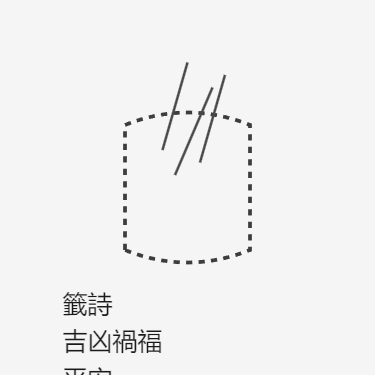

time: 7.53 ms (started: 2024-12-22 09:22:29 +00:00)


In [4]:
from IPython.display import Image

Image(filename='images/fortune_default.png')

## Panda dataframe

Convert to panda dataframe, for downstream processing


In [ ]:
all_chances_file = 'all_chances.json'
df_raw = pd.read_json(all_chances_file)
df_merged = df_raw
df_merged.fillna('', inplace=True)

print(df_merged.shape)
print(df_merged.loc[0, '籤詩'])
print(df_merged['籤名'].tolist()[-2:])
df_merged.info()

(100, 19)
['天開地闢結良緣', '日吉時良萬事全', '若得此籤非小可', '人行中正帝王宣']
['第九十九首', '第一百首']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         100 non-null    int64 
 1   籤名         100 non-null    object
 2   詩名         100 non-null    object
 3   詩運         100 non-null    object
 4   籤詩         100 non-null    object
 5   吉凶         100 non-null    object
 6   宮位         100 non-null    object
 7   詩意         100 non-null    object
 8   解曰         100 non-null    object
 9   聖意         100 non-null    object
 10  淺釋         100 non-null    object
 11  靈籤         100 non-null    object
 12  詳解         100 non-null    object
 13  img_url    100 non-null    object
 14  img_fname  100 non-null    object
 15  url1       100 non-null    object
 16  url3       100 non-null    object
 17  url4       100 non-null    object
 18  url2       100 non-null    object
dtyp

In [ ]:
# Display the resulting DataFrame
df_merged.head()

,id,籤名,詩名,詩運,籤詩,吉凶,宮位,詩意,解曰,聖意,淺釋,靈籤,詳解,img_url,img_fname,url1,url3,url4,url2
0,0,第一首,宋太祖黃袍加身,上上,"[天開地闢結良緣, 日吉時良萬事全, 若得此籤非小可, 人行中正帝王宣]",上籤,子宮,此卦盤古初開天地之象。諸事皆吉也。,急速非速，言來時值，觀音降事，報與君知。此簽天開地辟之象，凡事大吉利也。,"{'家宅': '祈福', '自身': '秋冬大利', '求財': '秋冬大利', '交易':...",天地開創之時，凡事充滿了新氣象，正是良辰吉時，萬事都已準備周全;能求得此簽之人，非同小可，帝...,天開地辟。結良緣是天地開創之象。為大吉大利之象也。日吉時良。萬事俱全順遂之命。能蒙神指示為此...,"此籤有""謀事在人""之意。提醒當事人，未雨綢繆。會成功的人，除了本身的努力進取之外，對將來的一...",https://www.lungshan.org.tw/fortune_sticks/ima...,images/fortune_1.jpg,https://www.lungshan.org.tw/fortune_sticks/pag...,https://www.golla.tw/chouqian/zhougong/1.html,https://www.sheup.org/winfo/7/894.html,https://www.0961223888.com/kannon/Kannon1.htm
1,1,第二首,姜太公渭水垂釣,中,"[鯨魚未化守江湖, 未許升騰離碧波, 異日崢嶸身變態, 從教一躍禹門過]",下籤,子宮,此卦鯨魚未變之象。凡事忍耐待時也。,得忍且忍，得耐且耐，身不用忙，功名自在。此簽鯨魚未變之象，凡事進退待時。,"{'家宅': '不安', '自身': '還願', '求財': '欠利', '交易': '未指...",就像魚兒尚未成熟，還不到可以離水飛昇的程度;此時忍耐守靜則吉，等到時機來臨之日，蛻變之時，必...,鯨魚未化守江湖。姜太公之受難時也。為大鯨未變之象。凡事進退待時。不可輕舉妄動。動則凶。靜則吉...,"此籤有""守時待勢""之意。意味當事人，隨遇而安。人的一生高低起伏，難免有不順遂的時候，若不如意...",https://www.lungshan.org.tw/fortune_sticks/ima...,images/fortune_2.jpg,https://www.lungshan.org.tw/fortune_sticks/pag...,https://www.golla.tw/chouqian/zhougong/2.html,https://www.sheup.org/winfo/7/893.html,https://www.0961223888.com/kannon/Kannon2.htm
2,2,第三首,燕將獨守聊城,__,"[衝風冒雨去還歸, 役役勞身似燕兒, 啣得泥來成疊後, 到頭疊壞復成泥]",下籤,子宮,此卦燕子啣坭之象。凡事勞心費力也。,千般用計，晨昏不停，誰知此事，到底無成。此簽燕子銜泥之象，凡事空心勞力。,"{'家宅': '先凶后吉', '自身': '謹防', '求財': '有', '交易': '成...",頂著風冒著雨來來回回，就像燕子般辛勤奔波不歇;忙碌費力含來的小泥團，好不容易堆砌成土塊，有個...,衝風冒雨去還歸。役役勞心似燕兒。君爾之運逢燕子銜泥築巢之象耶。空心徒勞。無益者。為先難後甘之...,"此籤有""束手無策""之意。奉勸當事人，勿舉棋不定。有些人個性剛直、做事一板一眼，臨事卻不知變通...",https://www.lungshan.org.tw/fortune_sticks/ima...,images/fortune_3.jpg,https://www.lungshan.org.tw/fortune_sticks/pag...,https://www.golla.tw/chouqian/zhougong/3.html,https://www.sheup.org/winfo/7/892.html,https://www.0961223888.com/kannon/Kannon3.htm
3,3,第四首,長樂老歷相五代,中中,"[菱花鏡破復重圓, 女再求夫男再婚, 自此門閭重改換, 更添福祿與兒孫]",上籤,子宮,此卦串鏡重圓之象。凡事勞心有貴也。,五五念五，騎龍跨虎，事雖勞心，於中有補。此簽破鏡重圓之象，凡事成就則吉。,"{'家宅': '欠利', '自身': '秋冬旺', '求財': '秋冬旺', '交易': '...",菱花破鏡如何能夠重圓，男女各有欲追求的姻緣;此後將有一番新氣象，惟再積德修善，功德更添福祿，...,菱花鏡破鏡重圓。為破鏡重圓之象。凡事成就吉者也。不是上上者。為中中之簽。是先凶後吉之簽。,"此籤有""歷久彌堅""之意。意味當事人，不改初衷。須知""人生以服務為目的""，無論各行各業，應秉持...",https://www.lungshan.org.tw/fortune_sticks/ima...,images/fortune_4.jpg,https://www.lungshan.org.tw/fortune_sticks/pag...,https://www.golla.tw/chouqian/zhougong/4.html,https://www.sheup.org/winfo/7/891.html,https://www.0961223888.com/kannon/Kannon4.htm
4,4,第五首,燕昭王為郭隗築黃金台,中平,"[一鋤掘地要求泉, 努力求之得最先, 無意俄然遇知己, 相逢攜手上青天]",中籤,丑宮,此卦錐地求泉之象。凡事先難后易也。,望中心事，今可方求，百事營謀，立地堪求。此簽堀土求泉之象，凡事勞心成就。,"{'家宅': '祈福', '自身': '利', '求財': '利', '交易': '合', ...",想要靠一支鋤頭挖得泉水，必定要非常努力才有可能得到;積極努力奮鬥，在無意間遇到了夥伴知己，互...,一鋤掘地妥求泉水。此象則表徵君之運途。是凡事謀略之後。勞心方有成就者也。努力向前必有化凶為吉...,"此籤有""休戚相關""之意。意味當事人，推誠相與。有些人為了打響自己的招牌，不惜砸下重金投資，或...",https://www.lungshan.org.tw/fortune_sticks/ima...,images/fortune_5.jpg,https://www.lungshan.org.tw/fortune_sticks/pag...,https://www.golla.tw/chouqian/zhougong/5.html,https://www.sheup.org/winfo/7/890.html,https://www.0961223888.com/kannon/Kannon5.htm


time: 98.8 ms (started: 2024-12-17 03:36:04 +00:00)


# 3.Neo4j Communication

### Create the initial graph structure

```cypher
CREATE (p1:Poem {number: 1, name: "第一首", ...})
-[:HAS_BODY]->(s1:Body {籤詩: "籤詩x4", 吉凶: "上籤", ...})
-[:HAS_EARTH_BRANCH]->(e1:EarthlyBranch {name: "子", ...})
-[:HAS_PURPOSE]->(i1:DivineIntention {purpose: "疾病", purpose_embedding: [], ...})
-[:HAS_PURPOSE_ANSWER]->(a1:PurposeAnswer {purpose: '疾病', answer: "'有驚'", answer_embedding: [], ...})
WITH p1, e1
MERGE (e1)-[:HAS_FIVE_ELEMENT]->(f1:FiveElement {name: "水"})
MERGE (e1)-[:HAS_ZODIAC]->(z1:Zodiac {name: "鼠"})
```

### Add a UserPrompt

```cypher
MATCH (p:Poem {number: $poem_number})
CREATE (up:UserPrompt {text: "求身體健康", llm_response: "good luck!", purpose_embedding: [], llm_response_embedding: []...})
-[:GENERATED_BY]->(l:LLM {model: $model, temperature: $temperature, max_tokens: $max_tokens})
CREATE (p)-[:HAS_PROMPT]->(up)
```

### Simple Search

```cypher
MATCH (p:Poem {number: 1})
MATCH (p)-[:HAS_BODY]->(b)
MATCH (p)-[:HAS_PURPOSE]->(i)
MATCH (i)-[:HAS_PURPOSE_ANSWER]->(a)
MATCH (p)-[:HAS_EARTH_BRANCH]->(e)
MATCH (e)-[:HAS_FIVE_ELEMENTS]->(f)
MATCH (e)-[:HAS_ZODIAC]->(z)
RETURN p.name, b.籤名, i.purpose, a.answer, e.name as 地支, f.name as 五行, z.name as 生肖, ...
```

### Similarity Search

```cypher
MATCH (p:Poem {number: 1})-[:HAS_PROMPT]->(up:UserPrompt)
OPTIONAL MATCH (up)-[:GENERATED_BY]->(llm:LLM)
WITH up, llm, gds.similarity.cosine(up.purpose_embedding, $new_userprompt_embedding) AS similarity
WHERE similarity > 0.75
RETURN similarity, up.llm_response, llm.model...
ORDER BY similarity DESC
LIMIT 3
```


## Connect to neo4j


In [ ]:
import os

from google.colab import userdata
from neo4j import Driver, GraphDatabase

if not os.environ.get('NEO4J_AUTH'):
    os.environ['NEO4J_AUTH'] = userdata.get('NEO4J_SANDBOX_nycu')
    os.environ['NEO4J_URL'] = userdata.get('NEO4J_SANDBOX_url')

if not os.environ.get('NEO4J_AUTH') or not os.environ.get('NEO4J_URL'):
    raise ValueError(
        'Please set the NEO4J_AUTH and URL environment variables.')

driver_sandbox: Driver = GraphDatabase.driver(
    os.environ.get('NEO4J_URL'),
    auth=('neo4j', os.environ.get('NEO4J_AUTH'))
)

Neo4jUtil.test_neo4j_connection(driver_sandbox)

1
Connection successful!
time: 93.1 ms (started: 2024-12-17 04:20:02 +00:00)


## Test search_poem_data


In [ ]:
# Usage
current_driver_sandbox = driver_sandbox

if True:
    poem_number = 57
    with current_driver_sandbox.session() as session:
        results = Neo4jUtil.search_poem_data(
            session=session, poem_number=poem_number)
        # pprint(result[0])
        poem = results[0]['Poem'][0]
        poem.pop('context_embedding')
        body = results[0]['Body'][0]
        pprint(poem)
        pprint(body)

{'context': 'You are an assistant specialized in interpreting divination '
            'results. Use the following [Context] to provide insights and '
            'advice to users based on their questions. Always format your '
            'responses according to the [Response Format] below, ensuring '
            'personalized interpretations and actionable advice.\n'
            '\n'
            '[Response Format]\n'
            ' 您抽到的籤是: [Include 籤名 here]\n'
            ' 籤詩: [Include full 籤詩 here]\n'
            ' \n'
            '籤詩解讀: \n'
            '\n'
            '小廟公建議: \n'
            '\n'
            '[Context]\n'
            ' 籤名: 【中籤】上中 第五十七首-甯戚飯牛叩角\n'
            '\n'
            '\n'
            '~籤詩~\n'
            '聞是聞非風過耳     \n'
            '好衣好祿日當空     \n'
            '君須記取他年事     \n'
            '汝意還同我意同     \n'
            '\n'
            '此籤有"隨機應變"之意。鼓勵當事人，積極表現。有些人很懂得如何隨機應變，有時連身邊看似不起眼的物事，都可以適時拿來運用，成功地為自己加分不少。須知很多機會往往稍縱即逝，要能夠把握契機。即使看似希望渺茫，但仍值得一試，說不定就此一舉成功。在自己本身方

## Test similarity_search_user_prompts


In [ ]:
# Usage
current_driver_sandbox = driver_sandbox

if True:
    poem_number = 57
    with current_driver_sandbox.session() as session:
        results = Neo4jUtil.similarity_search_user_prompts(
            session=session,
            poem_number=poem_number,
            new_user_prompt='求健康',
            threshold=0.1,
            top_n=3
        )
        print(results[0]['similarity'], '\n', results[0])

        results = Neo4jUtil.similarity_search_user_prompts(
            session=session,
            poem_number=poem_number,
            new_user_prompt='最近身體欠佳, 請給予指示',
            threshold=0.1,
            top_n=3
        )
        print(results[0]['similarity'], '\n', results[0])

0.43610176264730816 
 <Record similarity=0.43610176264730816 user_prompt='最近身體欠佳, 請給予指示' llm_response='您抽到的籤是: 【中籤】中中 第五十八首-羅隱歸咎越王  \n籤詩: 忠言善語君須記 莫向他方求別藝 勸君安守舊生涯 除卻有餘都不是\n\n籤詩解讀:\n這首籤詩提醒您要謹記忠言和善意的建議，特別是在健康方面，不要輕易嘗試新的療法或偏方。當下最重要的是保持現有的生活方式，避免過度操勞和不必要的壓力。這段時間，請多關注身邊親友的建議，他們的關心可能會帶來有益的啟示。\n\n小廟公建議:\n- 關於自身: 此時對您的健康不利，建議您多加留意身體狀況，及早就醫，並遵循醫生的專業建議。\n- 關於疾病: 目前健康狀況可能不太穩定，建議您保持規律的作息，適當休息，並多攝取營養。\n- 地支「丑」提醒您，適合從事需要耐力和毅力的活動，但要避免過度勞累。\n\n請務必保重身體，保持樂觀心態，祝您早日康復！' llm_model='gpt-4o' llm_temperature=0.5 llm_max_tokens=512>
1.0 
 <Record similarity=1.0 user_prompt='最近身體欠佳, 請給予指示' llm_response='您抽到的籤是: 【中籤】中中 第五十八首-羅隱歸咎越王  \n籤詩: 忠言善語君須記 莫向他方求別藝 勸君安守舊生涯 除卻有餘都不是\n\n籤詩解讀:\n這首籤詩提醒您要謹記忠言和善意的建議，特別是在健康方面，不要輕易嘗試新的療法或偏方。當下最重要的是保持現有的生活方式，避免過度操勞和不必要的壓力。這段時間，請多關注身邊親友的建議，他們的關心可能會帶來有益的啟示。\n\n小廟公建議:\n- 關於自身: 此時對您的健康不利，建議您多加留意身體狀況，及早就醫，並遵循醫生的專業建議。\n- 關於疾病: 目前健康狀況可能不太穩定，建議您保持規律的作息，適當休息，並多攝取營養。\n- 地支「丑」提醒您，適合從事需要耐力和毅力的活動，但要避免過度勞累。\n\n請務必保重身體，保持樂觀心態，祝您早日康復！' llm_model='gpt-4o' llm_temperature=0.5 llm_max_tokens=512>
time

# 4.Integrate with LLM API, Neo4j

- openai API https://github.com/openai/openai-python
- anthropic API https://github.com/anthropics/anthropic-sdk-python
- aisuite API https://github.com/andrewyng/aisuite
- neo4j API https://github.com/neo4j/neo4j-python-driver


## Use cases

**使用者**
求財運

**System Prompt**

Forget previous system prompt.

[System] You are an assistant for question-answering tasks regarding pray. Use the following pieces of retrieved [Context] to answer the question. Alwasy reply in Chinese Traditional with the format under [Response Format] section. In the end, say something like 'don't worry'、'good luck' (no needs to be the same) in short.

[Context]
籤名為二十四首-下籤巳宮

"此籤有”執迷不悟”之意。奉勸當事人，須知忠言必逆耳。看事情的角度不能光憑表面，必須多用點心，觀察入微、從裡到外，仔細分析評估求證。不要先入為主就認定一件事必定是如此。須知事事無絕對，很多事都有意外。對於他人的善意提醒與規勸，尤其在親朋好友方面，應思考必定有其道理，要能謙虛接受、謹記在心。切勿亳不在乎地當成耳邊風，免得吃虧在眼前，後悔莫及。

小廟公建議來自聖意如下, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成!
關於「家宅」: 不安
關於「自身」: 險
關於「求財」: 阻
關於「交易」: 難
關於「婚姻」: 待時
關於「六甲」: 祈福
關於「行人」: 阻
關於「田蠶」: 多災
關於「六畜」: 多災
關於「尋人」: 阻
關於「公訟」: 虧
關於「移徙」: 吉
關於「失物」: 難見
關於「疾病」: 急求神,
關於「山墳」: 不吉

潛在的指示為地支「巳」, 也可給求籤者做相關提醒

- 地理位置代表東南方
- 時間為上午 9 點至 11 點
- 十二生肖對應為蛇, 智慧, 神秘, 適合從事需要策略和洞察力的工作
- 五行為火, 火生土但火剋金 -若為上籤宜'烹飪', '熱情工作', '學習新技能', '社交活動', '創意表達'等 -若為下籤則注意'高溫環境', '火災風險', '過度熱情', '火氣過旺'等

[Response Format]

您抽到的籤是: [Include 籤名 here]
籤詩: [Include full 籤詩 here]

籤詩解讀:

小廟公建議:

**ChatGPT 回應**

您抽到的籤是: 第二十四首 - 下籤巳宮

籤詩解讀: 此籤顯示財運受阻，行事需格外謹慎。籤文提醒您，不要執著於表面的現象或已有的偏見，必須深入分析問題的根源。財運上的障礙可能來自不充分的判斷或對建議的忽視。聽取親朋好友的忠告，避免獨斷專行，才能避免更大的損失。

小廟公建議: 現階段不宜冒險投資或進行大的財務變動，應重視風險評估與求證。建議選擇上午 9 點至 11 點進行重要決策或行動，並尋求東南方的助力。五行屬火的行業或活動可能有一定幫助，但需注意火氣過旺引發的問題。請保持耐心，等待更有利的時機。

不必擔心，調整心態，轉危為機！


## Core integration functions

Integrate with
- Existing dataset (dataframe)
- System Prompt
- RAG Context
- OpenAPI


### TempleBase class


In [ ]:
import typing
from abc import ABC, abstractmethod

from pandas import DataFrame

TEMPERATURE = 0.75
DEFAULT_OPENAI_MODEL = 'gpt-4o'  # Default OpenAI model
DEFAULT_CLAUDE_MODEL = 'claude-3-5-sonnet-20241022'  # Default Claude model
DEFAULT_TOKENS = 2048  # Default token limit


class TempleBase(ABC):
    """
    Base class for EpochDrawing.
    Generate a large palette of visually distinct colors by combining multiple colormaps.
    """

    def __init__(self, client: typing.Any) -> None:
        """Initialize the TempleBase with a client."""
        super().__init__()
        self.client = client

    @abstractmethod
    def pray(
        self,
        df: DataFrame,
        lot_idx: int,
        prompt: str,
        temperature: float = TEMPERATURE
    ) -> list[typing.Tuple[str, str]]:
        """Call LLM to explain the poem (given a specific poem text)."""
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _send_request(
        self,
        messages: list[dict[str, str]],
        max_tokens: int,
        temperature: float,
        model: str = None
    ) -> tuple[str, str]:  # (model_name, response)
        """Send a request to the LLM and return the response."""
        raise NotImplementedError("Subclasses must implement this method")

    def resolve_messages(
        self,
        df: DataFrame,
        lot_idx: int,
        prompt: str
    ) -> list[str]:
        """Resolve messages for LLM interaction based on the provided DataFrame and prompt."""

        page_content = PoemUtil.format_rag_content(df=df, lot_idx=lot_idx)
        if page_content is None:
            page_content = '神明休息了, 請擇日再來!'

        context = SYS_PROMPT_TPL.format(context=page_content)
        messages = [
            {'role': 'system', 'content': context},
            {'role': 'user', 'content': prompt}
        ]
        return messages  # Return the constructed messages for LLM interaction

time: 2.09 ms (started: 2024-12-17 05:18:54 +00:00)


### TempleOpenAI

- openai models https://platform.openai.com/docs/models


In [ ]:
import os
import typing

from openai import OpenAI
from pandas import DataFrame


class TempleOpenAI(TempleBase):
    """OPENAI temple for interacting with OpenAI's API."""

    def __init__(self) -> None:
        """Initialize the TempleOpenAI with an OpenAI client."""
        client = OpenAI(
            # Default API key from environment variable
            api_key=os.environ.get('OPENAI_API_KEY')
        )
        super().__init__(client)
        self.models: list[str] = ['gpt-4o']  # List of available models

    def pray(
        self,
        df: DataFrame,
        lot_idx: int,
        prompt: str,
        temperature: float = TEMPERATURE
    ) -> list[typing.Tuple[str, str]]:
        """Call LLM to explain the poem (given a specific poem text)."""

        print(f'{lot_idx=}')
        messages = self.resolve_messages(df=df, lot_idx=lot_idx, prompt=prompt)
        response = self._send_request(
            messages=messages,
            max_tokens=DEFAULT_TOKENS,
            temperature=temperature,
            model=self.models[0],
        )
        return [response]  # Return a list containing the response

    def _send_request(
        self,
        messages: list[dict[str, str]],
        max_tokens: int,
        temperature: float,
        model: str = None
    ) -> tuple[str, str]: # (model_name, response)
        """Send a request to the LLM and return the response."""

        print(f'Sending request to {model}')
        print(f'Messages: {messages}')
        try:
            response = self.client.chat.completions.create(
                model=model or self.models[0],
                max_tokens=max_tokens,
                messages=messages,
                temperature=temperature,
            )
            print(response)
            return (model, response.choices[0].message.content.strip())
        except Exception as e:
            print(f'Error in {model}: {e}')
            return (model, str(e))  # Return error message as string

time: 2.12 ms (started: 2024-12-17 05:18:55 +00:00)


### TempleAnthropic


In [ ]:
import os
import typing

from anthropic import Anthropic
from pandas import DataFrame


class TempleAnthropic(TempleBase):
    """Anthropic temple for interacting with Anthropic's API."""

    def __init__(self) -> None:
        """Initialize the TempleAnthropic with an Anthropic client."""
        client = Anthropic(
            # Default API key from environment variable
            api_key=os.environ.get("ANTHROPIC_API_KEY")
        )
        super().__init__(client)
        # List of available models
        self.models: list[str] = ['claude-3-5-sonnet-20241022']

    def pray(
        self,
        df: DataFrame,
        lot_idx: int,
        prompt: str,
        temperature: float = TEMPERATURE
    ) -> list[typing.Tuple[str, str]]:
        """Call LLM to explain the poem (given a specific poem text)."""

        print(f'{lot_idx=}')
        messages = self.resolve_messages(df=df, lot_idx=lot_idx, prompt=prompt)
        response = self._send_request(
            messages=messages,
            max_tokens=DEFAULT_TOKENS,
            temperature=temperature,
            model=self.models[0],
        )
        return [response]  # Return a list containing the response

    def _send_request(
        self,
        messages: list[dict[str, str]],
        max_tokens: int,
        temperature: float,
        model: str = None
    ) -> tuple[str, str]: # (model_name, response)
        """Send a request to the LLM and return the response."""

        print(f'Sending request to {model}')  # Debugging statement
        print(f'Messages: {messages}')  # Debugging statement
        try:
            system_prompt = next(
                prompt for prompt in messages if prompt['role'] == 'system')['content']
            user_messages = [
                prompt for prompt in messages if prompt['role'] == 'user']

            message = self.client.messages.create(
                model=model or self.models[0],
                max_tokens=max_tokens,
                system=system_prompt,
                messages=user_messages,
                temperature=temperature,
            )
            print(message)  # Debugging statement
            return (model, message.content[0].text.strip())
        except Exception as e:
            print(f'Error in {model}: {e}')
            return (model, str(e))  # Return error message as string

time: 1.77 ms (started: 2024-12-17 05:18:55 +00:00)


### TempleSuite


In [ ]:
import typing

import aisuite as ai
from pandas import DataFrame


class TempleSuite(TempleBase):
    """Hybrid (OpenAI, Anthropic) temples for interacting with multiple LLMs."""

    def __init__(self) -> None:
        """Initialize the TempleSuite with an AI client."""
        client = ai.Client()
        super().__init__(client)
        # List of available models
        self.models: list[str] = ["openai:gpt-4o",
                                  "anthropic:claude-3-5-sonnet-20240620"]

    def pray(
        self,
        df: DataFrame,
        lot_idx: int,
        prompt: str,
        model: str = None,  # Ignored in this implementation
        temperature: float = TEMPERATURE
    ) -> list[typing.Tuple[str, str]]:
        """Call LLMs to explain the poem (given a specific poem text)."""

        print(f'{lot_idx=}')  # Debugging statement
        messages = self.resolve_messages(df=df, lot_idx=lot_idx, prompt=prompt)
        responses = []

        for model in self.models:
            response = self._send_request(
                max_tokens=DEFAULT_TOKENS,
                messages=messages,
                temperature=temperature,
                model=model,
            )
            responses.append(response)  # Collect responses from each model
        return responses  # Return all collected responses

    def _send_request(
        self,
        max_tokens: int,
        messages: list[dict[str, str]],
        temperature: float,
        model: str
    ) -> tuple[str, str]: # (model_name, response)
        """Send a request to the specified LLM and return the response."""
        try:
            response = self.client.chat.completions.create(
                model=model,
                max_tokens=max_tokens,
                messages=messages,
                temperature=temperature,
            )
            print(response)  # Debugging statement
            return (model, response.choices[0].message.content.strip())
        except Exception as e:
            print(f'Error in {model}: {e}')
            return (model, str(e))  # Return error message as string

time: 1.44 ms (started: 2024-12-17 05:18:55 +00:00)


### TempleNeo4j


In [ ]:
import typing

from pandas import DataFrame


class TempleNeo4j(TempleBase):
    """Neo4j history for managing interactions with LLMs."""

    def __init__(self, driver: typing.Any) -> None:
        """Initialize the TempleNeo4j with a Neo4j driver."""
        super().__init__(driver)  # driver as a client
        self.temples: list[dict[str, typing.Any]] = [
            {
                'client': TempleOpenAI(),
                'model': DEFAULT_OPENAI_MODEL
            },
            {
                'client': TempleAnthropic(),
                'model': DEFAULT_CLAUDE_MODEL
            }
        ]

    def pray(
        self,
        df: DataFrame,
        lot_idx: int,
        prompt: str,
        temperature: float = TEMPERATURE
    ) -> list[typing.Tuple[str, str]]:
        """Call LLMs to explain the poem (given a specific poem text)."""

        print(f'{lot_idx=}')  # Debugging statement
        responses = []
        poem_number = lot_idx + 1

        with self.client.session() as session:
            try:
                similar_prompts = Neo4jUtil.similarity_search_user_prompts(
                    session=session,
                    poem_number=poem_number,
                    new_user_prompt=prompt,
                    threshold=0.7,
                    top_n=2
                )
                if similar_prompts and len(similar_prompts) > 0:
                    for data in similar_prompts:
                        responses.append(
                            (data['llm_model'], data['llm_response'])
                        )
                    return responses  # Return responses from similar prompts
            except Exception as e:
                print(f'Error in Neo4j find_similar_prompts: {e}')

        messages = self.resolve_messages(df=df, lot_idx=lot_idx, prompt=prompt)

        for temple in self.temples:
            response = temple['client']._send_request(
                messages=messages,
                max_tokens=DEFAULT_TOKENS,
                temperature=temperature,
                model=temple['model'],
            )

            if not response:
                continue

            responses.append(response)
            with self.client.session() as session:
                try:
                    Neo4jUtil.update_poem_with_user_prompt(
                        session=session,
                        poem_number=poem_number,
                        prompt=prompt,
                        llm_response=response[1],
                        model=response[0],
                        temperature=temperature,
                        max_tokens=DEFAULT_TOKENS,
                    )
                except Exception as e:
                    print(f'Error in Neo4j store_related_information: {e}')
        return responses  # Return all collected responses

    def _send_request(
        self,
        messages: list[typing.Dict[str, str]],
        max_tokens: int,
        temperature: float,
        model: str = None
    ) -> typing.Tuple[str, str]: # (model_name, response)
        """Send a request to the specified LLM and return the response."""
        raise NotImplementedError("Subclasses must implement this method")

time: 2.07 ms (started: 2024-12-17 05:18:55 +00:00)


## Connect to backend services


### Try system prompt


In [ ]:
test_num = 1  # The 2nd poem
test_content = PoemUtil.format_rag_content(df=df_merged, lot_idx=test_num)
test_system_prompt = SYS_PROMPT_TPL.format(context=test_content)
pprint(test_system_prompt)

('You are an assistant specialized in interpreting divination results. Use the '
 'following [Context] to provide insights and advice to users based on their '
 'questions. Always format your responses according to the [Response Format] '
 'below, ensuring personalized interpretations and actionable advice.\n'
 '\n'
 '\n'
 '[Response Format] \n'
 '您抽到的籤是: [Include 籤名 here] \n'
 '籤詩: [Include full 籤詩 here] \n'
 '\n'
 '\n'
 '籤詩解讀: \n'
 '\n'
 '\n'
 '小廟公建議: \n'
 '[Context] 籤名: 【下籤】中 第二首-姜太公渭水垂釣 \n'
 '\n'
 '\n'
 '~籤詩~ \n'
 '鯨魚未化守江湖     \n'
 '未許升騰離碧波     \n'
 '異日崢嶸身變態     \n'
 '從教一躍禹門過     \n'
 '\n'
 '\n'
 '此籤有"守時待勢"之意。意味當事人，隨遇而安。人的一生高低起伏，難免有不順遂的時候，若不如意的情況接踵而來，更易叫人灰心喪志。須知事在人為，切勿被一時的失意所打垮。此時煩躁冒失有害無益，切忌沉不住氣、衝動妄為。凡事保持心平氣和，忍一時風平浪靜。縱使遭人譏嘲誤解，只要知所當為，又何須耿耿於懷。不要放棄任何希望，凡事樂觀，相信自己並堅持到底，必有苦盡甘來、如願以償之日。\n'
 '\n'
 '\n'
 '小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! \n'
 '關於家宅: 不安\n'
 '關於自身: 還願\n'
 '關於求財: 欠利\n'
 '關於交易: 未指示\n'
 '關於婚姻: 難\n'
 '關於六甲: 作福\n'
 '關於行人: 平安\n'
 '關於田蠶: 吉\n'
 '關於六畜: 不利\n'
 '關

### Set environment variables


In [ ]:
import os

# Protect your sensitive API_KEY, goto colab > secrets > add key
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_key_nycu')
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')

time: 2.1 s (started: 2024-12-17 04:21:42 +00:00)


### Connect to neo4j


In [ ]:
import os

from google.colab import userdata
from neo4j import Driver, GraphDatabase

if not os.environ.get('NEO4J_AUTH'):
    os.environ['NEO4J_AUTH'] = userdata.get('NEO4J_SANDBOX_nycu')
    os.environ['NEO4J_URL'] = userdata.get('NEO4J_SANDBOX_url')

if not os.environ.get('NEO4J_AUTH') or not os.environ.get('NEO4J_URL'):
    raise ValueError(
        'Please set the NEO4J_AUTH and URL environment variables.')

driver: Driver = GraphDatabase.driver(
    os.environ.get('NEO4J_URL'),
    auth=('neo4j', os.environ.get('NEO4J_AUTH'))
)

Neo4jUtil.test_neo4j_connection(driver)

1
Connection successful!
time: 162 ms (started: 2024-12-17 04:21:47 +00:00)


### Test neo4j


In [ ]:
# Testing API
test_num = 57
test_prompt = '健康'
neo4j_temple = TempleNeo4j(driver)
current_driver = driver

if True:
    with current_driver.session() as session:
        test_query = """
        MATCH (p:Poem {number: $number})-[:HAS_PROMPT]->(up:UserPrompt)
        OPTIONAL MATCH (up)-[:GENERATED_BY]->(llm:LLM)
        RETURN up.text AS prompt_text,
               COLLECT(DISTINCT llm) AS LLM
        LIMIT 1
        """
        test_result = session.run(test_query, {'number': test_num}).single()
        print(test_result)

if True:
    with current_driver.session() as session:
        test_similar_prompts = Neo4jUtil.similarity_search_user_prompts(
            session=session,
            poem_number=test_num,
            new_user_prompt=test_prompt,
            threshold=0.1,
            top_n=1
        )
        pprint(test_similar_prompts)

if False:
    test_responses = neo4j_temple.pray(
        df=df_merged,
        lot_idx=test_num,
        prompt=test_prompt,
        temperature=TEMPERATURE,
    )

    for test_model_name, test_response in test_responses:
        print(test_model_name, test_response)

<Record prompt_text='最近身體欠佳, 請給予指示' LLM=[<Node element_id='4:c7659caf-56a1-4098-b619-932192c2b6b8:2093' labels=frozenset({'LLM'}) properties={'max_tokens': 512, 'temperature': 0.25, 'model': 'gpt-4o'}>, <Node element_id='4:c7659caf-56a1-4098-b619-932192c2b6b8:2095' labels=frozenset({'LLM'}) properties={'max_tokens': 512, 'temperature': 0.5, 'model': 'gpt-4o'}>, <Node element_id='4:c7659caf-56a1-4098-b619-932192c2b6b8:2097' labels=frozenset({'LLM'}) properties={'max_tokens': 512, 'temperature': 0.75, 'model': 'gpt-4o'}>, <Node element_id='4:c7659caf-56a1-4098-b619-932192c2b6b8:2099' labels=frozenset({'LLM'}) properties={'max_tokens': 512, 'temperature': 0.9, 'model': 'gpt-4o'}>, <Node element_id='4:c7659caf-56a1-4098-b619-932192c2b6b8:2105' labels=frozenset({'LLM'}) properties={'max_tokens': 1024, 'temperature': 0.25, 'model': 'gpt-4o'}>, <Node element_id='4:c7659caf-56a1-4098-b619-932192c2b6b8:2107' labels=frozenset({'LLM'}) properties={'max_tokens': 1024, 'temperature': 0.5, 'model': 

### Test openai


In [ ]:
# Testing API
test_num = 0
test_prompt = '求財'

if True:
    openai_temple = TempleOpenAI()
    test_responses = openai_temple.pray(
        df=df_merged,
        lot_idx=test_num,
        prompt=test_prompt,
        temperature=TEMPERATURE,
    )

    for test_model_name, test_response in test_responses:
        print(test_model_name, test_response)

lot_idx=0
Sending request to gpt-4o
Messages: [{'role': 'system', 'content': 'You are an assistant specialized in interpreting divination results. Use the following [Context] to provide insights and advice to users based on their questions. Always format your responses according to the [Response Format] below, ensuring personalized interpretations and actionable advice.\n\n\n[Response Format] \n您抽到的籤是: [Include 籤名 here] \n籤詩: [Include full 籤詩 here] \n\n\n籤詩解讀: \n\n\n小廟公建議: \n[Context] 籤名: 【上籤】上上 第一首-宋太祖黃袍加身 \n\n\n~籤詩~ \n天開地闢結良緣     \n日吉時良萬事全     \n若得此籤非小可     \n人行中正帝王宣     \n\n\n此籤有"謀事在人"之意。提醒當事人，未雨綢繆。會成功的人，除了本身的努力進取之外，對將來的一切，也早已預先考慮且準備周詳。須知每個人的頭上都有一片天，成敗操之在己。平日穩紮穩打、厚實基礎，更不間斷地充實自我，為將來預作準備。凡事深謀遠慮、從長計畫，對於身邊親朋好友的建議，不妨虛心接受。等到時機成熟之時，亦是準備充足之時，自可從容不迫，滿載而歸。\n\n\n小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! \n關於家宅: 祈福\n關於自身: 秋冬大利\n關於求財: 秋冬大利\n關於交易: 成\n關於婚姻: 成\n關於六甲: 生男\n關於行人: 至\n關於田蠶: 好\n關於六畜: 好\n關於尋人: 見\n關於公訟: 吉\n關於移徙: 未指示\n關於失物: 東北\n關於疾病: 設送\n關於山墳: 吉\n\n\n潛在的指示為地支「子」, 也可給求籤者做相關提醒:

### Test anthropic


In [ ]:
# Testing API
test_num = 0
test_prompt = '求財'

if True:
    anthropic_temple = TempleAnthropic()
    test_responses = anthropic_temple.pray(
        df=df_merged,
        lot_idx=test_num,
        prompt=test_prompt,
        temperature=TEMPERATURE,
    )

    for test_model_name, test_response in test_responses:
        print(test_model_name, test_response)

lot_idx=0
Sending request to claude-3-5-sonnet-20241022
Messages: [{'role': 'system', 'content': 'You are an assistant specialized in interpreting divination results. Use the following [Context] to provide insights and advice to users based on their questions. Always format your responses according to the [Response Format] below, ensuring personalized interpretations and actionable advice.\n\n\n[Response Format] \n您抽到的籤是: [Include 籤名 here] \n籤詩: [Include full 籤詩 here] \n\n\n籤詩解讀: \n\n\n小廟公建議: \n[Context] 籤名: 【上籤】上上 第一首-宋太祖黃袍加身 \n\n\n~籤詩~ \n天開地闢結良緣     \n日吉時良萬事全     \n若得此籤非小可     \n人行中正帝王宣     \n\n\n此籤有"謀事在人"之意。提醒當事人，未雨綢繆。會成功的人，除了本身的努力進取之外，對將來的一切，也早已預先考慮且準備周詳。須知每個人的頭上都有一片天，成敗操之在己。平日穩紮穩打、厚實基礎，更不間斷地充實自我，為將來預作準備。凡事深謀遠慮、從長計畫，對於身邊親朋好友的建議，不妨虛心接受。等到時機成熟之時，亦是準備充足之時，自可從容不迫，滿載而歸。\n\n\n小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! \n關於家宅: 祈福\n關於自身: 秋冬大利\n關於求財: 秋冬大利\n關於交易: 成\n關於婚姻: 成\n關於六甲: 生男\n關於行人: 至\n關於田蠶: 好\n關於六畜: 好\n關於尋人: 見\n關於公訟: 吉\n關於移徙: 未指示\n關於失物: 東北\n關於疾病: 設送\n關於山墳: 吉\n\n\n潛在的指示

### Test aisuite


In [ ]:
# Testing API
test_num = 0
test_prompt = '求財'

if False:
    aisuite_temple = TempleSuite()
    test_responses = aisuite_temple.pray(
        df=df_merged,
        lot_idx=test_num,
        prompt=test_prompt,
        temperature=TEMPERATURE,
    )

    for test_model_name, test_response in test_responses:
        print(test_model_name, test_response)

lot_idx=0
ChatCompletion(id='chatcmpl-AeLYP4gHV9UyVU1tHupQ85RBibaQI', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='您抽到的籤是: 【上籤】上上 第一首-宋太祖黃袍加身  \n籤詩:  \n天開地闢結良緣  \n日吉時良萬事全  \n若得此籤非小可  \n人行中正帝王宣  \n\n籤詩解讀:  \n這支籤傳達了「謀事在人」的理念，對於求財的您來說，這意味著如果您能夠做好充分準備，財運將會非常可觀。這支籤提醒您要穩紮穩打地構築基礎，時刻準備迎接機會。您需要對未來有充分的考慮和計劃，並虛心聽取他人的建議。當時機成熟時，您將能夠從容地實現財務上的成功。\n\n小廟公建議:  \n在秋冬季節，您的財運特別旺盛，因此可以考慮在這段時間進行重要的投資或交易。保持謹慎並且對市場變化保持敏感。若有任何交易或投資的機會到來，您可以積極把握。注意北方方向的機會，可能會有意外的財源。最重要的是，保持中正，誠實和可靠是您成功的關鍵。\n\n祝您好運！', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1734179337, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_a79d8dac1f', usage=CompletionUsage(completion_tokens=315, prompt_tokens=796, total_tokens=1111, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=P

# 5.Web GUI

- https://www.gradio.app/
- https://www.gradio.app/playground


## UIManager & Utilities


In [ ]:
import random
import time
import typing


class UIManager:
    """
    A class for managing file operations, including creating directories,
    exporting data to JSON files, and importing data from JSON files.
    """

    # Class attribute to store the client (for OpenAI, Anthropic, Neo4j, etc.)
    client: typing.Optional[typing.Any] = None

    @classmethod
    def initialize_client(cls, neo4j_driver: typing.Any) -> None:
        """Initialize the client if it hasn't been initialized yet."""
        if cls.client is None:
            cls.client = TempleNeo4j(driver=neo4j_driver)

    @staticmethod
    def set_question(question: str) -> str:
        """Display the user's question."""
        return f'今天求的是: {question}'

    @staticmethod
    def draw_lot(question: str) -> typing.Tuple[str, int, str]:
        """User presses to draw a lot."""
        current_lot = random.randint(1, TOTAL_LOTS)
        lot_idx = current_lot - 1

        current_image = PoemUtil.get_value_by_index(
            df=df_merged,
            idx=lot_idx,
            col_name='img_fname',
            default_value='images/fortune_default.png'
        )
        return f'你抽到第 {current_lot} 首籤', current_lot, current_image

    @staticmethod
    def toss_cup(question: str, lot_number: int) -> typing.Tuple[str, str]:
        """User presses to toss the cup."""
        if not question:
            return '請先輸入要求什麼！', ''

        if lot_number is None or lot_number <= 0:
            return '請先抽籤！', ''

        lot_idx = lot_number - 1
        toss_result = random.randint(0, 2)

        if toss_result == 0:
            responses = UIManager.client.pray(
                df=df_merged,
                lot_idx=lot_idx,
                prompt=question,
            )
            summary = [f'第 {lot_number} 首解籤如下:\n']
            for model_name, answer in responses:
                summary.append(f'{model_name} >> {answer}\n')
            return '聖杯!', '\n'.join(summary)
        elif toss_result == 1:
            return '笑杯!。重新抽籤...', ''
        else:
            return '無杯!。重新抽籤...', ''

    @staticmethod
    def draw_lot_yield(
        question: str
    ) -> typing.Generator[tuple[str, int, str], None, None]:
        """User presses to draw a lot with streaming effect."""

        summary, current_lot, current_image = UIManager.draw_lot(question)
        yield '', current_lot, current_image

        streaming_summary = ''
        for char in summary:
            streaming_summary += char
            time.sleep(0.05)  # Delay for streaming effect
            yield streaming_summary, current_lot, current_image

    @staticmethod
    def toss_cup_yield(
        question: str,
        lot_number: int
    ) -> typing.Generator[tuple[str, str], None, None]:
        """User presses to toss the cup with streaming effect."""

        result, summary = UIManager.toss_cup(question, lot_number)
        yield result, ''

        streaming_summary = ''
        for char in summary:
            streaming_summary += char
            time.sleep(0.05)  # Delay for streaming effect
            yield result, streaming_summary  # Update the summary text incrementally

time: 2.15 ms (started: 2024-12-17 05:26:15 +00:00)


## Gradio Interface


In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    """Declare Gradio interactive app."""

    gr.Markdown('## 小小廟公')
    gr.Markdown('輸入所求為何,然後抽籤與擲筊,直到獲得聖杯。')

    # Step-1
    user_question = gr.Textbox(
        label='今天求的是?', placeholder='財? 事業? 婚姻? 健康? 外出?...')
    question_summary = gr.Textbox(label='(系統)問題摘要', interactive=False)

    # Step-2
    draw_poem_button = gr.Button('請抽籤')
    poem_display = gr.Textbox(label='(系統)抽籤結果', interactive=False)
    poem_number = gr.Number(label='(系統)籤號', interactive=False)
    poem_image = gr.Image(label='(系統)籤詩', interactive=False,
                          elem_id="fixed-size-image")

    # Step-3
    toss_cup_button = gr.Button('請筊杯')
    toss_result_display = gr.Textbox(label='(系統)筊杯結果', interactive=False)

    # Step-Final 籤詩解釋結果
    result_summary = gr.Textbox(label='(系統)籤運結果', interactive=False)

    # Event bindings
    draw_poem_button.click(
        fn=UIManager.set_question,
        inputs=[user_question],
        outputs=[question_summary]
    )
    draw_poem_button.click(
        # fn=UIManager.draw_lot,
        fn=UIManager.draw_lot_yield,
        inputs=[user_question],
        outputs=[poem_display, poem_number, poem_image],
        show_progress=True,
    )

    toss_cup_button.click(
        # fn=UIManager.toss_cup,
        fn=UIManager.toss_cup_yield,
        inputs=[user_question, poem_number],
        outputs=[toss_result_display, result_summary],
        show_progress=True,
    )


# Launch the app for testing
# if __name__ == '__main__':
#     demo.launch()

time: 1.14 s (started: 2024-12-17 05:26:16 +00:00)


### Launch


In [ ]:
# Ensure the UIManager & its client is initialized
UIManager.initialize_client(neo4j_driver=driver)

try:
    demo.close()
except:
    pass
demo.launch(share=True)
# demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://79216560d503206122.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


lot_idx=26
Sending request to gpt-4o
Messages: [{'role': 'system', 'content': 'You are an assistant specialized in interpreting divination results. Use the following [Context] to provide insights and advice to users based on their questions. Always format your responses according to the [Response Format] below, ensuring personalized interpretations and actionable advice.\n\n\n[Response Format] \n您抽到的籤是: [Include 籤名 here] \n籤詩: [Include full 籤詩 here] \n\n\n籤詩解讀: \n\n\n小廟公建議: \n[Context] 籤名: 【中籤】中中 第二十七首-李鄴侯白衣宰相 \n\n\n~籤詩~ \n一謀一用一番機     \n慮後疑前不敢為     \n時至自然逢貴助     \n銀牆鐵壁好安居     \n\n\n此籤有"戒慎恐懼"之意。提醒當事人，凡事自食其力。有時人會想依附有權有勢的對象，並希望"靠山"越穩越好，認為如此便可高枕無憂。但任何事絕無僥倖。故事中，李鄴侯之所以堅辭所有的官職與厚祿，即是因為他心中雪亮，知道"伴君如伴虎"、樹大易招風、更不願被名與利束縛。因此不要妄想一步登天，須知"靠山山倒、靠人人倒"的道理。凡事腳踏實地，靠自己的實力來打拚。在與人合作方面，也應知見好就收，切莫貪圖過多的利益，免得沉溺其中、無法收拾。\n\n\n小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! \n關於家宅: 安\n關於自身: 吉\n關於求財: 有\n關於交易: 難\n關於婚姻: 阻\n關於六甲: 女\n關於行人: 遲\n關於田蠶: 熟\n關於六畜: 利\n關於尋人: 遲\n關於公訟: 宜和\n關於移徙: 吉\n關於失物: 無蹤\n關於疾病: 延安\n關於山墳: